In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [3]:
# Load the Dataset
img = "C:/Users/hp/Downloads/UTKFace"
# labels age, gender 
img_paths=[]
age_labels = []
gender_label=[]

for filename in tqdm(os.listdir(img)):
    img_path = os.path.join(img, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    img_paths.append(img_path)
    age_labels.append(age)
    gender_label.append(gender)
    

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# convert to dataframe

df = pd.DataFrame()
df['image'], df['age'], df['gender'] = img_paths, age_labels, gender_label
df.head()

image  age  gender
0  C:/Users/hp/Downloads/UTKFace\100_0_0_20170112...  100       0
1  C:/Users/hp/Downloads/UTKFace\100_0_0_20170112...  100       0
2  C:/Users/hp/Downloads/UTKFace\100_1_0_20170110...  100       1
3  C:/Users/hp/Downloads/UTKFace\100_1_0_20170112...  100       1
4  C:/Users/hp/Downloads/UTKFace\100_1_0_20170112...  100       1

In [5]:
#map labels for gender

gender_dict = {0:'Male', 1:'Female'}

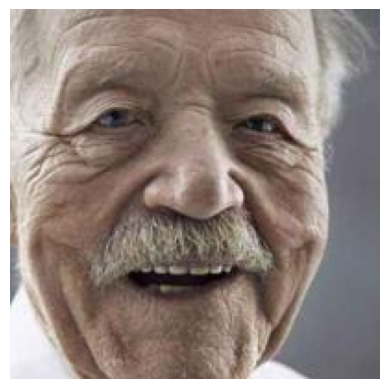

In [6]:
# Exploratory Data Analysis

from PIL import Image
pic = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(pic);

<Axes: xlabel='age', ylabel='Density'>

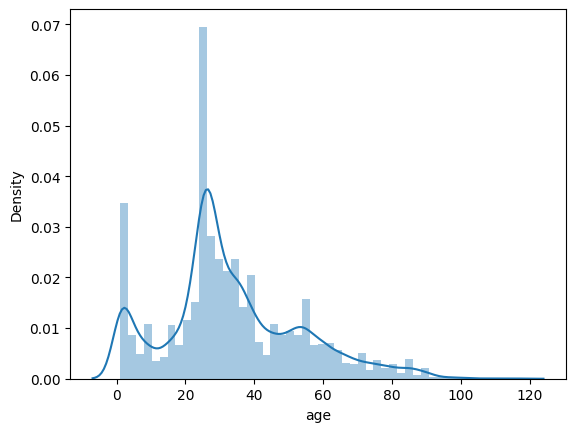

In [7]:
sns.distplot(df['age'])

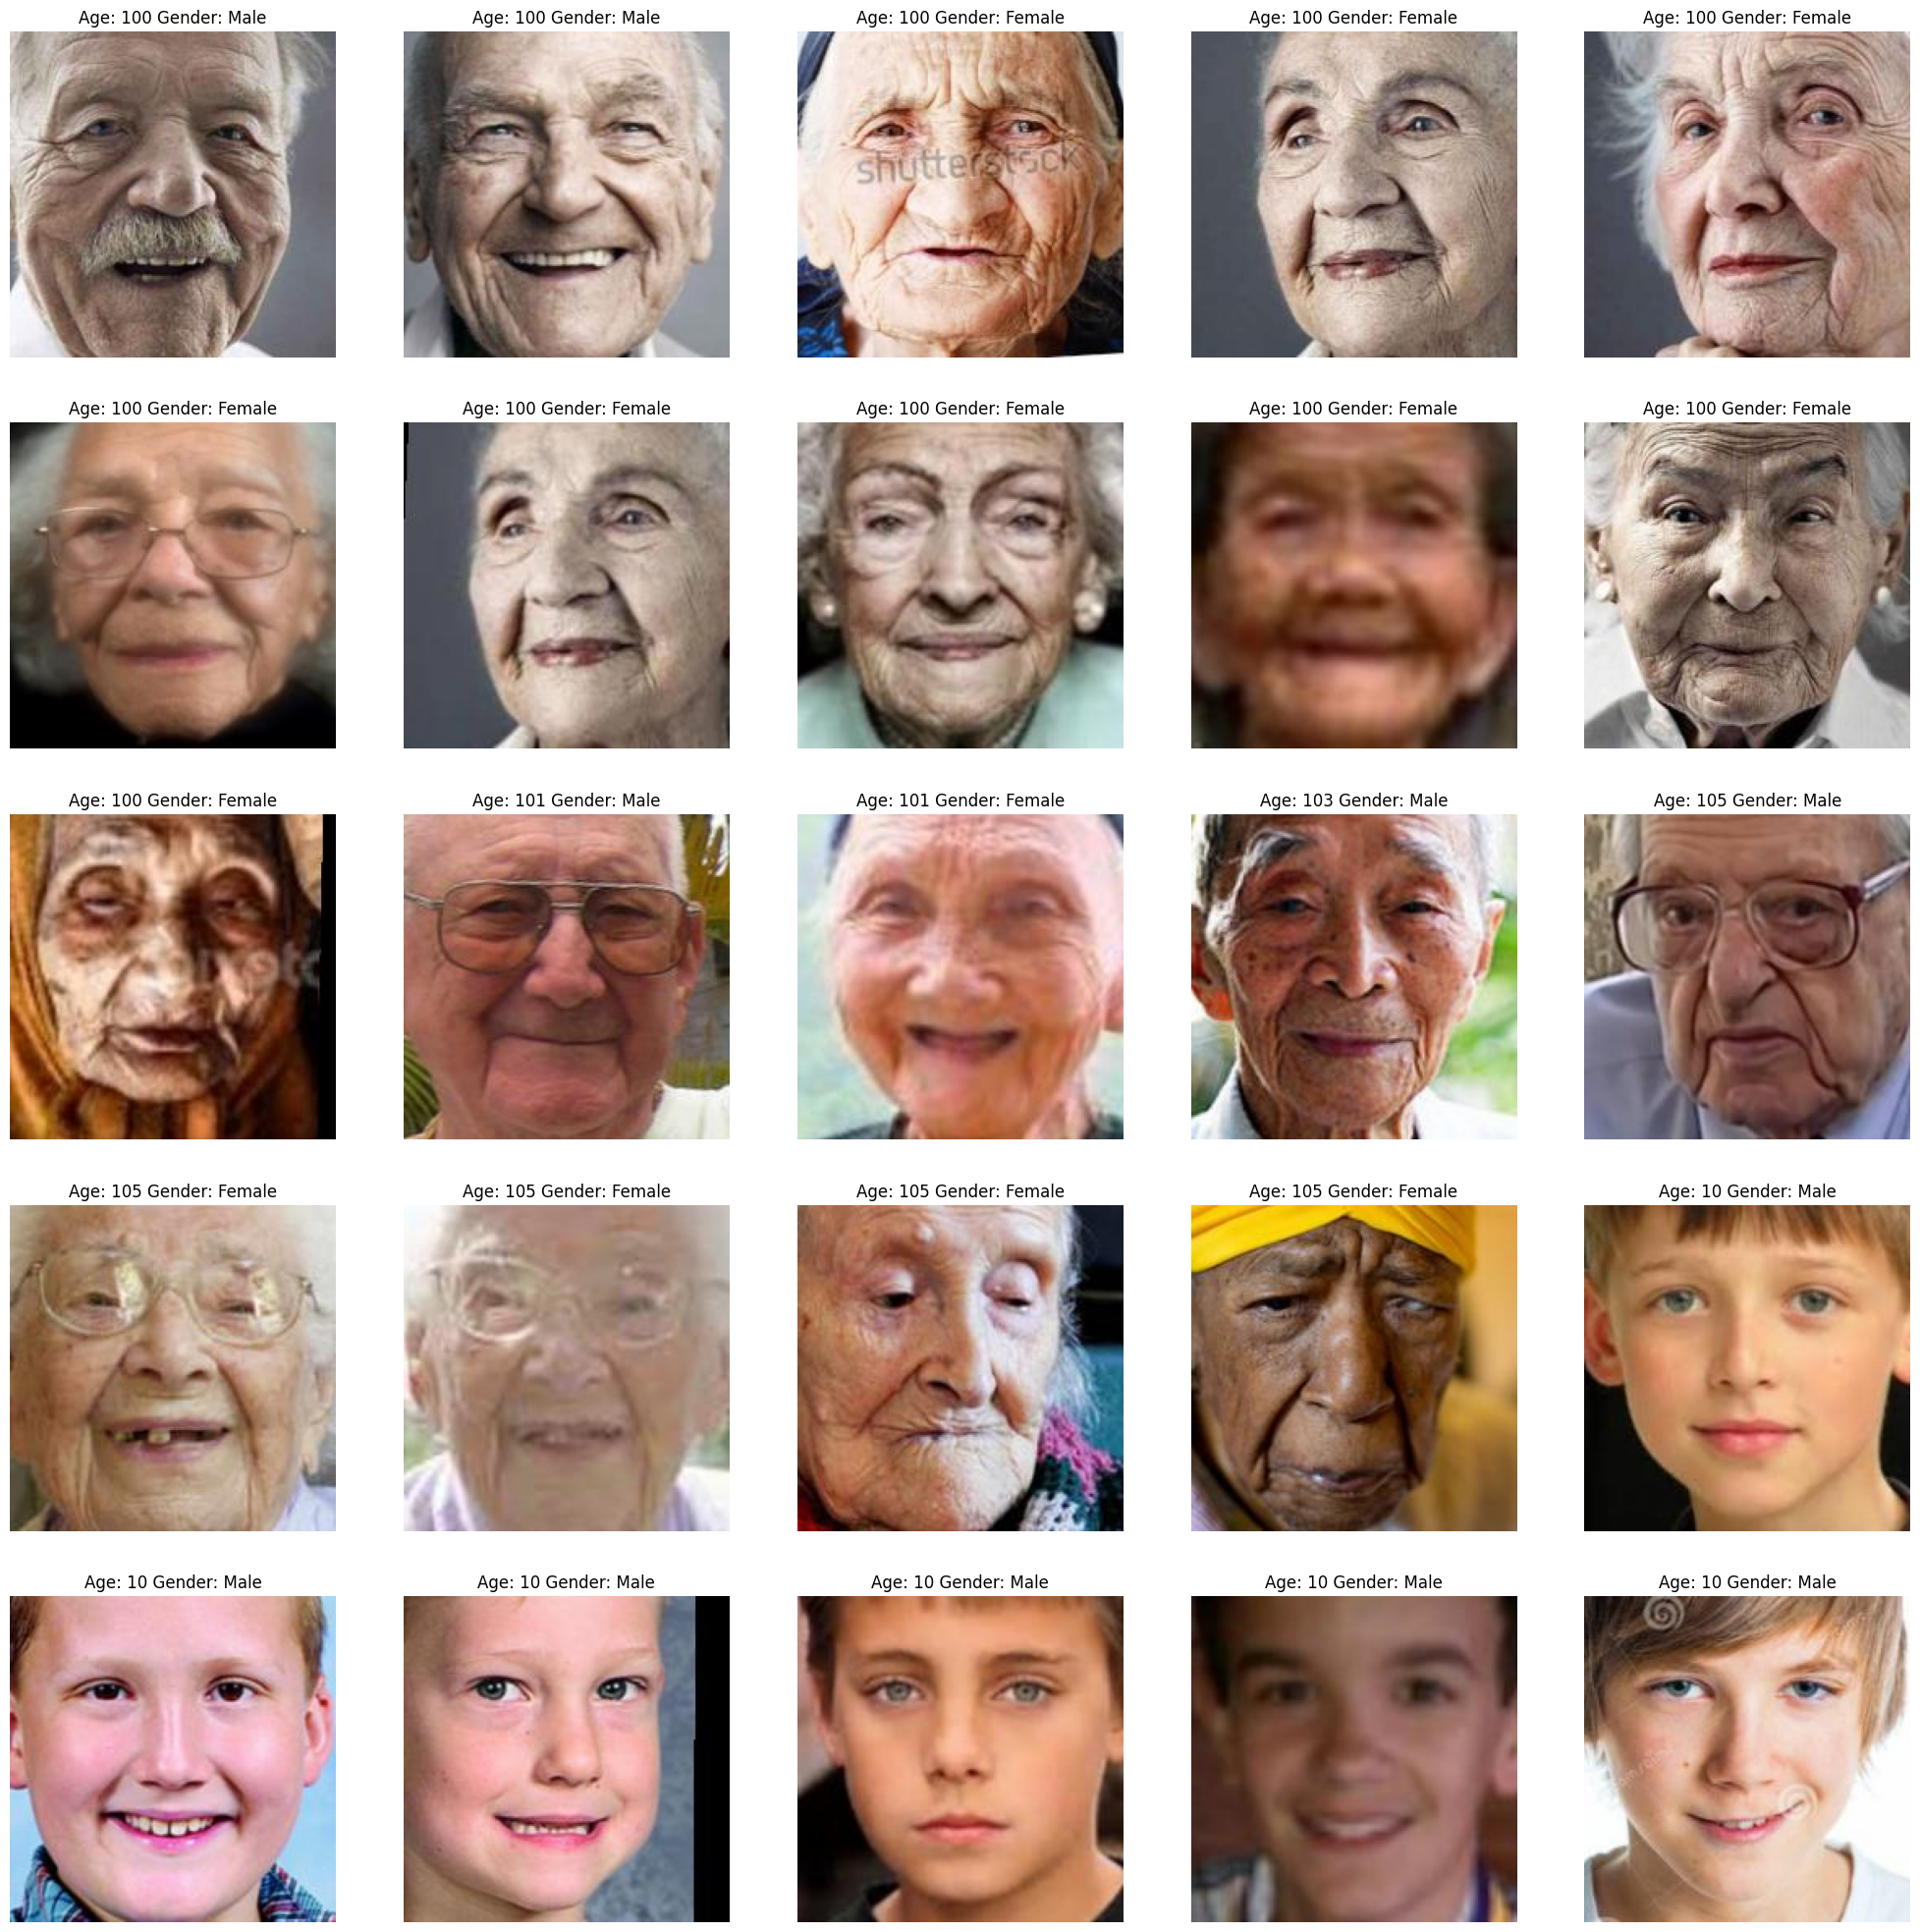

In [8]:
# to display grid of images
plt.figure(figsize=(25,25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')  # Open image and convert to grayscale
        img = img.resize((128, 128), Image.LANCZOS)  # Resize with Lanczos filter for antialiasing
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [10]:
x = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
x.shape

(23708, 128, 128, 1)

In [12]:
#normalize the images
x = x/255.0

In [13]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [14]:
input_shape=(128,128,1)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define input shape
input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)

# Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=inputs, outputs=[output_1, output_2])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics={'gender_out': 'accuracy', 'age_out': 'mae'})


In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 126, 126, 32)      │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 63, 63, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 61, 61, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 30, 30, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 28, 28, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 14, 14, 128)       │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 12, 12, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 6, 6, 256)         │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 9216)              │               0 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │       2,359,552 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │       2,359,552 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gender_out (Dense)            │ (None, 1)                 │             257 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ age_out (Dense)               │ (None, 1)                 │             25

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

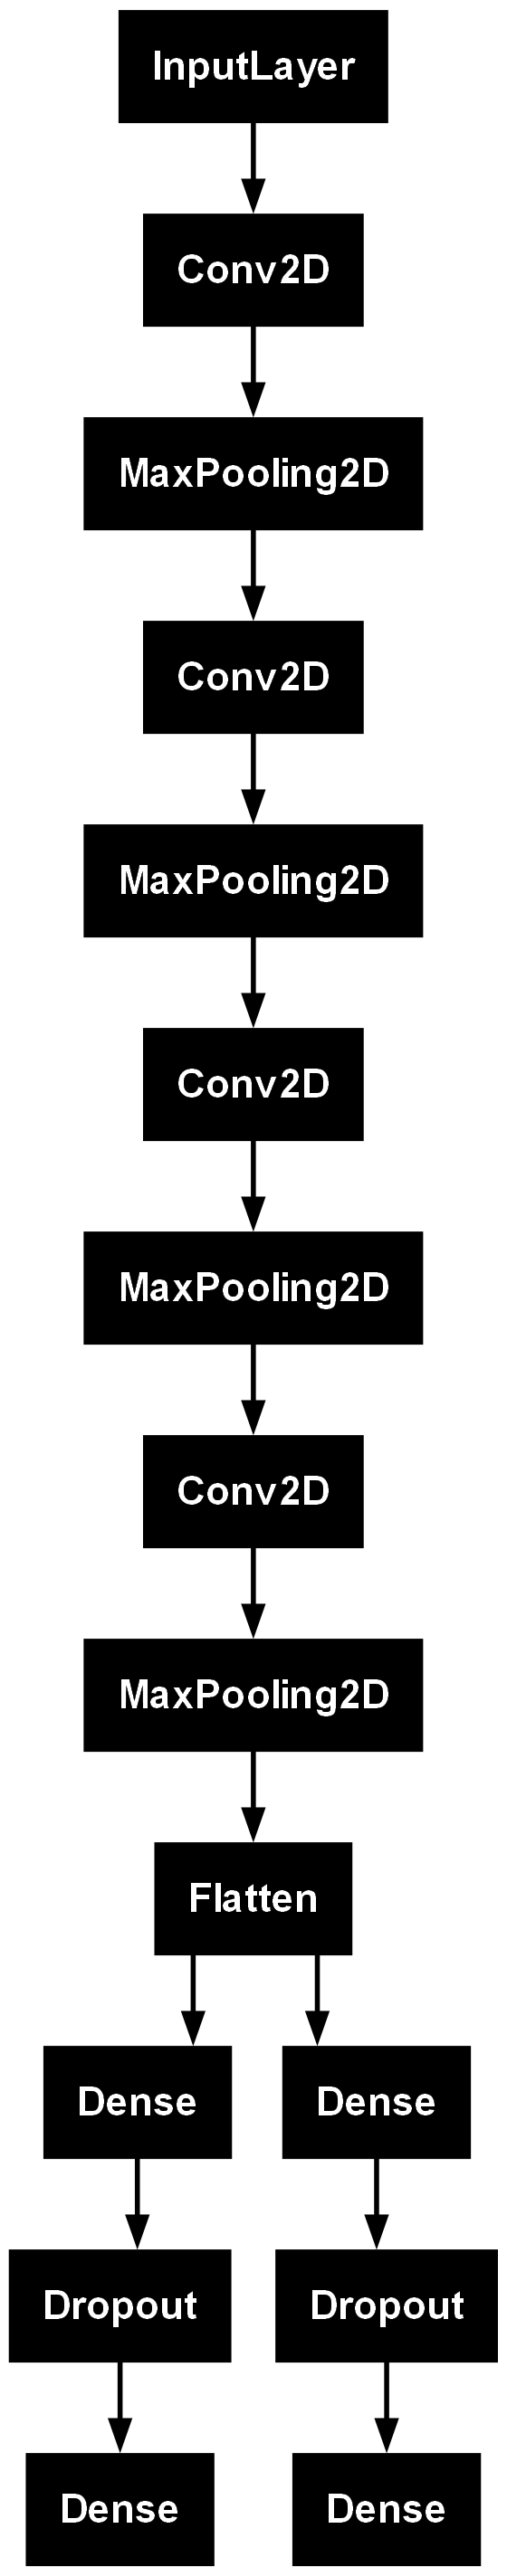

In [17]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Gender: Male 
Predicted Age 36


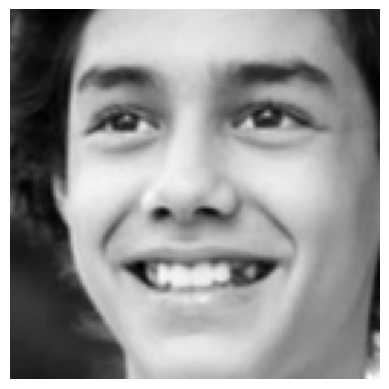

In [22]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]],"Original Age:", y_age[image_index] )

pred = model.predict(x[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age", pred_age)
plt.axis('off')
plt.imshow(x[image_index].reshape(128,128), cmap ='gray');

Original Gender: Male Original Age: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted Gender: Male 
Predicted Age 36


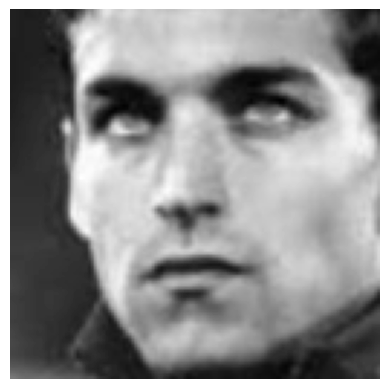

In [23]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]],"Original Age:", y_age[image_index] )

pred = model.predict(x[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age", pred_age)
plt.axis('off')
plt.imshow(x[image_index].reshape(128,128), cmap ='gray');

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Gender: Male
Predicted Age: 35


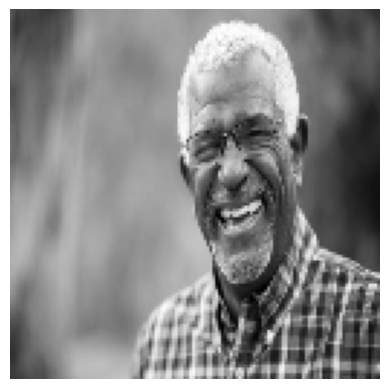

In [30]:
import cv2
import numpy as np

# Load your new image
new_image_path = 'man1.jpg'  # Replace 'path_to_your_new_image.jpg' with the actual path to your new image
new_image = cv2.imread(new_image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Preprocess the image
new_image = cv2.resize(new_image, (128, 128))  # Resize the image to match the input size of your model
new_image = new_image.astype('float32') / 255.0  # Normalize the pixel values

# Reshape the image for prediction
new_image = np.reshape(new_image, (1, 128, 128, 1))

# Make predictions using your trained model
pred = model.predict(new_image)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

# Print the predicted gender and age
print("Predicted Gender:", pred_gender)
print("Predicted Age:", pred_age)

# Display the new image
plt.axis('off')
plt.imshow(new_image.reshape(128, 128), cmap='gray')
plt.show()
